# Initial setup


## Pip installs

In [1]:
# Various pip
!pip install tensorflow
!pip install transformers
!pip install datasets
!pip install contractions
!pip install --upgrade nltk
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 37.3 MB/s eta 0:00:00


## Imports

In [2]:
# Dataframe management
import pandas as pd

# Data manipulation
import numpy as np
import random
import os
import re
import contractions
from tqdm import tqdm

# NNs
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.models import Model

# Transformers
import transformers
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

# Convert to HuggingFace dataset
import pyarrow as pa
from datasets import Dataset
import datasets

# Sklearn for train test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import BernoulliNB

# Preprocessing text
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from spellchecker import SpellChecker


# Wordfreq to get the italian wordssss
#from wordfreq import top_n_list

# File imports
#from google.colab import drive

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Get the datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#PER FAVORE NON CANCELLATE :(
PATH_ELISA_MAIN_DATA = '/content/drive/My Drive/NLP_HATESPEECH/data/mainDataEN.csv'
PATH_ELISA_HASPEEDE2 = '/content/drive/My Drive/NLP_HATESPEECH/haspeede2_dev/haspeede2_dev_taskAB.tsv'
PATH_ELISA_MISOGYNY_DATA = '/content/drive/My Drive/NLP_HATESPEECH/misogyny_data/AMI2020_TrainingSet/AMI2020_training_raw.tsv'

In [5]:
# Get dataset
df_en = pd.read_csv(PATH_ELISA_MAIN_DATA)
df_ita_hs = pd.read_csv(PATH_ELISA_HASPEEDE2, sep='\t')
df_ita_m = pd.read_csv(PATH_ELISA_MISOGYNY_DATA, sep="\t")
#df_en = pd.read_csv("mainDataEN.csv")
#df_ita_hs = pd.read_csv("haspeede2_dev_taskAB.tsv", sep='\t')
#df_ita_m = pd.read_csv("AMI2020_training_raw.tsv", sep="\t")

In [6]:
df_ita_hs

,id,text,hs,stereotype
0,2066,"È terrorismo anche questo, per mettere in uno ...",0,0
1,2045,@user @user infatti finché ci hanno guadagnato...,0,0
2,61,"Corriere: Tangenti, Mafia Capitale dimenticata...",0,0
3,1259,"@user ad uno ad uno, perché quando i migranti ...",0,0
4,949,Il divertimento del giorno? Trovare i patrioti...,0,0
...,...,...,...,...
6832,9340,Gli stati nazionali devono essere pronti a rin...,0,0
6833,9121,Il ministro dell'interno della Germania #Horst...,0,0
6834,8549,#Salvini: In Italia troppi si sono montati la ...,0,0
6835,9240,@user @user Chi giubila in buona fede non ha c...,0,0


# Dataset preprocessing

In [7]:
# English hate speech dataset
df_en.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# Italian hate_speech / stereotype dataset
df_ita_hs.head()

,id,text,hs,stereotype
0,2066,"È terrorismo anche questo, per mettere in uno ...",0,0
1,2045,@user @user infatti finché ci hanno guadagnato...,0,0
2,61,"Corriere: Tangenti, Mafia Capitale dimenticata...",0,0
3,1259,"@user ad uno ad uno, perché quando i migranti ...",0,0
4,949,Il divertimento del giorno? Trovare i patrioti...,0,0


In [ ]:
# Italian misogyny / aggressiveness
df_ita_m.head()

,id,text,misogynous,aggressiveness
0,1,@KassemAmin4 @Laylasexgdr Fatti trovare te lo...,1,1
1,2,@meb Tu dovresti ricominciare dai semafori a f...,1,1
2,3,"Amore,sei presentabile? Xchè così via Skype ti...",1,1
3,4,"@Il_nulla Salvo poi mandare la culona a Mosca,...",1,0
4,5,@GiorgiaMeloni @FratellidItaIia Vediamo Gentil...,1,1


## Uniform hate speech in a single column in the english dataset

Hate speech is the OR between the column `hate_speech` and `offensive_language`

In [8]:
def is_hate_speech(df):
  if df['class'] == 2:
    return 0 # No hate speech
  else:
     return 1 # Hate speech

df_en['hate_speech'] = df_en.apply(is_hate_speech, axis=1)

df_en = df_en.drop(['Unnamed: 0','count', 'offensive_language', 'neither', 'class'], axis=1)

## Uniform the ita datasets

The solely `stereotype` rows differ too much from the general hate speech texts, potentially impacting the models' performance.

The `misogynous` and `aggressiveness` columns where merged in a sinlge one using the same OR approach.

In [9]:
# Stereotypes are considered as hate speech
#df_ita_hs['hate_speech'] = df_ita_hs['stereotype'] | df_ita_hs['hs']
df_ita_hs = df_ita_hs.drop(['id', 'stereotype'], axis=1)
df_ita_hs = df_ita_hs.rename(columns={'hs': 'hate_speech'})
df_ita_hs = df_ita_hs.rename(columns={'text ': 'tweet'}) #there was a space

# Merge 'misogynous' and 'aggressiveness' column into a new hate speech column.
df_ita_m['hate_speech'] = df_ita_m['misogynous'] | df_ita_m['aggressiveness']
df_ita_m = df_ita_m.drop(['id', 'misogynous', 'aggressiveness'], axis=1)
df_ita_m = df_ita_m.rename(columns={'text': 'tweet'})

## Create a single uniform ita dataset

In [10]:
# Concatenate the datasets vertically
df_ita = pd.concat([df_ita_hs, df_ita_m], axis=0, ignore_index=True)

# Reset the index of the merged dataset
df_ita = df_ita.reset_index(drop=True)

In [11]:
print("Number of rows:", df_en.shape[0])
df_en.head()

Number of rows: 24783


,hate_speech,tweet
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
print("Number of rows:", df_ita.shape[0])
df_ita.head()

Number of rows: 11837


,tweet,hate_speech
0,"È terrorismo anche questo, per mettere in uno ...",0
1,@user @user infatti finché ci hanno guadagnato...,0
2,"Corriere: Tangenti, Mafia Capitale dimenticata...",0
3,"@user ad uno ad uno, perché quando i migranti ...",0
4,Il divertimento del giorno? Trovare i patrioti...,0


Example of non hate speech in the english dataset.

Generally we have observed:

- low number of swear words
- heavy presence of **intercalations** and "modern internet slang"


In [12]:
df_en[df_en['hate_speech'] == 0].iloc[32]['tweet']

'"@TEE_JONEZ: @KingCuh @16stanleys I\'m not mad cuh hahaha" suure.. tuku ho ita! &#128514;&#128514;'

Example of hate speech in the english dataset.

Generally we have observed:

- heavy number of swear words, generally with directed insults
- heavy presence of **intercalations** and "modern internet slang"


In [13]:
df_en[df_en['hate_speech'] == 1].iloc[10]['tweet']

'" Murda Gang bitch its Gang Land "'

Example of hate speech in the italian dataset.

The main difference with the english dataset is the difference in what was catalogated as hate speech. Besides the usual insults, the other side of hate speech tweets are more "sophisticated", ranging from politics to racism and discrimination. These latter kinds were not that present in the english dataset

In [14]:
df_ita[df_ita['hate_speech'] == 1].iloc[10]['tweet']

'Floris presentatore senza spina dorsale dovresti PARLARE, INDAGARE,DENUNCIARE tutto il giorno degli immigrati iniettati in Italia #dimartedì '

### Verifying Class Imbalance

In [ ]:
print("Class imbalance for english data\n")
print("Non Hate Speech:", df_en[df_en['hate_speech']==0].shape[0])
print("\nHate Speech:\t", df_en[df_en['hate_speech']==1].shape[0])

Class imbalance for english data

Non Hate Speech: 4163

Hate Speech:	 20620


English data are heavily imbalanced towards hate speech equal to 1 class.

In [ ]:
print("class imbalance for italian data")
print("Non Hate Speech:", df_ita[df_ita['hate_speech']==0].shape[0])

print("\nHate Speech:\t", df_ita[df_ita['hate_speech']==1].shape[0])

class imbalance for italian data
Non Hate Speech: 6734

Hate Speech:	 5103


## Perform train/test split

Definition of the random seed for repitability

In [15]:
seed = 42

# Random seed function
def set_random_seeds(seed: int):
  # Sets the random seed for reproducibility
  os.environ['PYTHONHASHSEED']=str(seed)
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # new flag present in tf 2.0+
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

set_random_seeds(seed=42)

### Italian dataframe

In [16]:
# Training data for the italian dataframe
train_ita, test_ita = train_test_split(df_ita, test_size=0.2, random_state=seed)

# Train
X_train_ita = train_ita['tweet'].reset_index(drop=True)
Y_train_ita = train_ita['hate_speech'].reset_index(drop=True)

# Test
X_test_ita = test_ita['tweet'].reset_index(drop=True)
Y_test_ita = test_ita['hate_speech'].reset_index(drop=True)

### English dataframe

In [17]:
# Training data for the italian dataframe
train_en, test_en = train_test_split(df_en, test_size=0.2, random_state=seed)

# Train
X_train_en = train_en['tweet'].reset_index(drop=True)
Y_train_en = train_en['hate_speech'].reset_index(drop=True)

# Test
X_test_en = test_en['tweet'].reset_index(drop=True)
Y_test_en = test_en['hate_speech'].reset_index(drop=True)

# THE BIBLE I FOLLOW

https://github.com/nlptown/nlp-notebooks/blob/master/Multilingual%20Embeddings%20-%203.%20Transfer%20Learning.ipynb

---


# Model

## Multilingual word embeddings

To have the multilingual embedding space we use aligned embeddings.

Start by downloading set of embeddings from the MUSE library, are fastText Wikipedia supervised word embeddings.


In [18]:
!wget https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec -O wiki.en.vec
!wget https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.it.vec -O wiki.it.vec

--2023-08-28 08:46:04--  https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.en.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.15, 52.84.251.114, 52.84.251.27, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.251.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628614720 (599M) [text/plain]
Saving to: ‘wiki.en.vec’

wiki.en.vec         100%[===================>] 599.49M   132MB/s    in 4.4s    

2023-08-28 08:46:08 (136 MB/s) - ‘wiki.en.vec’ saved [628614720/628614720]

--2023-08-28 08:46:08--  https://dl.fbaipublicfiles.com/arrival/vectors/wiki.multi.it.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.15, 52.84.251.114, 52.84.251.27, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.251.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 628718043 (600M) [text/plain]
Saving to: ‘wiki.it.vec’

wiki.it.vec         100%[============

The vec file are fastText Wikipedia supervised word embeddings for our languages (eng and ita) which are aligned in a single vector space.

The main idea behind [Multilingual word Embeddings](https://github.com/facebookresearch/MUSE) is to align different word embeddings into a single shared spatial representation.

Now, from the vec files we extract:
- The list of the embedding
- The dictionary in the form ["word": id] to create a link between each word in the embedding with its row in the embedding list (id)

In [19]:
# Given the embeddings file path, produce the:
#   - embeddings → list of the embeddings of the words in wiki
#   - embedding_word2id → dictionary with each word and relative index in the embedding list
def load_vectors(embedding_file_path):
    print("Loading vectors from", embedding_file_path)
    embeddings = []
    word2id = {}
    with open(embedding_file_path, 'r', encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            word, emb = line.rstrip().split(' ', 1)
            emb = np.fromstring(emb, sep=' ')
            assert word not in word2id, 'word found twice'
            embeddings.append(emb)
            word2id[word] = len(word2id)

    embeddings = np.vstack(embeddings)
    return embeddings, word2id

embeddings_en, embedding_word2id_en = load_vectors("wiki.en.vec")
embeddings_it, embedding_word2id_it = load_vectors("wiki.it.vec")

Loading vectors from wiki.en.vec
Loading vectors from wiki.it.vec


In [ ]:
print("Embedding size: ", len(embeddings_en), "\n")
embeddings_en

Embedding size:  200000 



array([[-0.0112864 , -0.00206967, -0.0515041 , ...,  0.0435525 ,
        -0.00774608,  0.0724234 ],
       [-0.0469256 , -0.00058526, -0.0750844 , ...,  0.0267626 ,
        -0.0513555 ,  0.0166127 ],
       [-0.0324474 , -0.0462027 , -0.00872643, ...,  0.0826505 ,
        -0.0649553 ,  0.0175795 ],
       ...,
       [-0.0608303 , -0.0172956 , -0.101635  , ...,  0.102298  ,
         0.0479459 ,  0.0387411 ],
       [-0.0867473 , -0.00469176, -0.104337  , ..., -0.00478122,
         0.130826  , -0.0207968 ],
       [-0.0119003 , -0.0123243 , -0.065963  , ...,  0.0184328 ,
        -0.0295059 , -0.0160871 ]])

In [ ]:
embedding_word2id_en

{',': 0,
 '.': 1,
 'the': 2,
 '</s>': 3,
 'of': 4,
 '-': 5,
 'in': 6,
 'and': 7,
 "'": 8,
 ')': 9,
 '(': 10,
 'to': 11,
 'a': 12,
 'is': 13,
 'was': 14,
 'on': 15,
 's': 16,
 'for': 17,
 'as': 18,
 'by': 19,
 'that': 20,
 'it': 21,
 'with': 22,
 'from': 23,
 'at': 24,
 'he': 25,
 'this': 26,
 'be': 27,
 'i': 28,
 'an': 29,
 'utc': 30,
 'his': 31,
 'not': 32,
 '–': 33,
 'are': 34,
 'or': 35,
 'talk': 36,
 'which': 37,
 'also': 38,
 'has': 39,
 'were': 40,
 'but': 41,
 'have': 42,
 '#': 43,
 'one': 44,
 'rd': 45,
 'new': 46,
 'first': 47,
 'page': 48,
 'no': 49,
 'you': 50,
 'they': 51,
 'had': 52,
 'article': 53,
 't': 54,
 'who': 55,
 '?': 56,
 'all': 57,
 'their': 58,
 'there': 59,
 'been': 60,
 'made': 61,
 'its': 62,
 'people': 63,
 'may': 64,
 'after': 65,
 '%': 66,
 'other': 67,
 'should': 68,
 'two': 69,
 'score': 70,
 'her': 71,
 'can': 72,
 'would': 73,
 'more': 74,
 'if': 75,
 'she': 76,
 'about': 77,
 'when': 78,
 'time': 79,
 'team': 80,
 'american': 81,
 'such': 82,
 'th': 

### Test of the multilingual space

In [20]:
def get_nn(word, src_emb, src_word2id, tgt_emb, tgt_word2id, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word_emb = src_emb[src_word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], list(tgt_word2id.keys())[list(tgt_word2id.values()).index(idx)]))

In [21]:
# printing nearest neighbors in the source space eng → eng
src_word = "cat"
get_nn(src_word, embeddings_en, embedding_word2id_en, embeddings_en, embedding_word2id_en, K=5)

Nearest neighbors of "cat":
1.0000 - cat
0.7322 - cats
0.6453 - kitten
0.6381 - dog
0.6218 - kittens


In [22]:
# printing nearest neighbors in the target space eng → ita
src_word = "cat"
get_nn(src_word, embeddings_en, embedding_word2id_en, embeddings_it, embedding_word2id_it, K=5)

Nearest neighbors of "cat":
0.5640 - gatto
0.5588 - cat
0.5308 - topo
0.4969 - randagio
0.4937 - cane


In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([embeddings_en, embeddings_it]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):
    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

Variance explained: 0.06


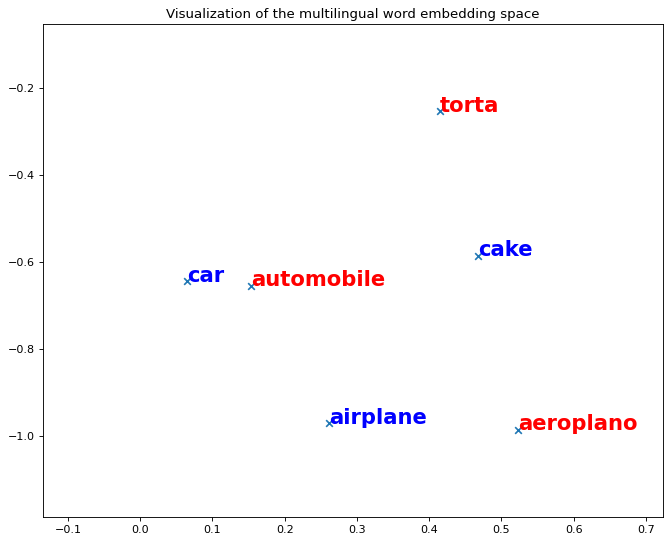

In [ ]:
# get 5 random input words
src_words = ['airplane', 'cake', "car"]
tgt_words = ['aeroplano', 'torta', "automobile"]

# assert words in dictionaries
for sw in src_words:
    assert sw in embedding_word2id_en, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in embedding_word2id_it, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, embedding_word2id_en, embeddings_en, tgt_words, embedding_word2id_it, embeddings_it, pca)

## Correctly format the texts for the NN

In [27]:
# Deinfe some variables
VOCABULARY_SIZE = 20000 # half the size of the embeddings
EMBEDDING_DIM = 300
SEQ_LENGTH = 300

# We insert <start>, <pad>, <unk>
INDEX_FROM = 3

Manual insertion of the start token.

Even though all the tweets in the datasets were obtained when the maximum length of a tweet was 280, we decided to implement the start token in case we decided to change the datasets and work with the new tweet length (up to 4000)

In [24]:
# Remove tags
def remove_tags(text):
    tag = r'[@#][\w.-]+'
    clean_text = re.sub(tag, '', text)
    return clean_text

# Remove urls
def remove_urls(text):
    url = r'https?://\S+|www\.\S+'
    clean_text = re.sub(url, '', text)
    return clean_text

# Remove &
def remove_ampersand(text):
    pattern = r'&[^ ]+'
    clean_text = re.sub(pattern, '', text)
    return clean_text

# Remove emoticons
def remove_emoticons(text):
    emoticons = r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF\u2600-\u26FF\u2700-\u27BF\u24C2\u3030\u303D\u3297\u3299\u203C\u2049\u00A9\u00AE\u2122\u2139]+'
    clean_text = re.sub(emoticons, '', text)
    return clean_text

# Remove retweets
def remove_RT(text):
    rt = r'RT : \s*'
    clean_text = re.sub(rt, '', text)
    return clean_text

# Correct typos
def correct_typos(text):
  spell = SpellChecker()
  words = text.split()

  corrected_words = []

  for word in words:
      corrected_word = spell.correction(word)
      if corrected_word is None:
          corrected_words.append(word)
      else:
          corrected_words.append(corrected_word)

  return " ".join(corrected_words)



# Preprocessing function for tweets
def preprocess_tweets(text, cntr=False, stopword="en", start=False):
  # Remove urls
  text = remove_urls(text)

  # Remove tags
  text = remove_tags(text)

  # Remove emoticons
  text = remove_emoticons(text)

  # Remove emoticons
  text = remove_ampersand(text)

  # Remove RT
  text = remove_RT(text)

  # Remove numbers
  text = re.sub(r'\d+', '', text)

  # Get rid of double spaces
  text = re.sub(' +', ' ', text)

  # Correct typos TROPPO LENTOOOOOOOOOOOOOOOOOOOOOOO
  #text = correct_typos(text)


  if cntr:
    text = " ".join([contractions.fix(word) for word in text.split()])

  if start:
    text = '<start> ' + text

  return text


In [25]:
X_train_en = [preprocess_tweets(text, cntr=True, start=True) for text in X_train_en]
X_test_en = [preprocess_tweets(text, cntr=True, start=True) for text in X_test_en]

X_train_ita = [preprocess_tweets(text, start=True) for text in X_train_ita]
X_test_ita = [preprocess_tweets(text, start=True) for text in X_test_ita]

100%|██████████| 19826/19826 [00:00<00:00, 21127.98it/s]


In [ ]:
X_train_en

['<start> well how else will white people get us to forget our horrific past other than to paint a pretty picture of ho',
 '<start> Funny thing is....it is not just the people doing it. It is the people who seeing these pics and judging the birds. Just as wrong.',
 '<start> ": ": Nigga messed with the wrong bitch',
 '<start> bitch ass nigggaaa',
 '<start> S/o that real bitch',
 '<start> speaking about me all the time tryna make me look bad like you was not just eating my pussy .',
 '<start> Nah Mimi a bitch',
 '<start> ": Baseball season for the win. " This is where the love started',
 '<start> you always hatin lmao',
 '<start> Why are nudes called nudes? I would rather be like " hey girl send me the tits and ass hoe "',
 '<start> RT Baby I cooked Bae: What is for dinner? Me: That bitch you been texting',
 '<start> pussy ass schedule',
 '<start> Stay home then bitch fuck you',
 '<start> okay but how many people really care if you can see a girls nips through her shirt',
 '<start> Now b

### Tokenizers

In [28]:
def list_of_words(sequence, tokenizer):
  result = []
  for text in sequence:
    text_list = []
    for word in text:
      text_list.append(tokenizer.index_word.get(word))

    result.append(text_list)

  return result

def clean_stopwords(texts_list, lang="en"):
  result = []

  if lang == "en":
    stp = stopwords.words('english')
  elif lang == "it":
    stp = stopwords.words('italian')

  for text in texts_list:

    text_clean = []

    for word in text:
      if word not in stp and word not in string.punctuation:
        text_clean.append(word)

    result.append(text_clean)

  return result


def clean_to_id(text_list, tokenizer):
  result = []

  for text in text_list:
    text_to_id = []
    for word in text:
      text_to_id.append(tokenizer.word_index.get(word))

    result.append(text_to_id)

  return result

In [29]:
def remove_stopwords(text_list, tokenizer, lang="en"):

  text_list = list_of_words(text_list, tokenizer)
  text_list = clean_stopwords(text_list, lang)
  text_list = clean_to_id(text_list, tokenizer)

  return text_list

In [30]:
# create the tokenizer
t_en = Tokenizer(oov_token="<unk>", num_words=VOCABULARY_SIZE+INDEX_FROM-1, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

# fit the tokenizer on the documents
t_en.fit_on_texts(X_train_en)

t_en.word_index['<pad>'] = 0
t_en.index_word[0] = '<pad>'

# summarize what was learneda
print("List of all the words and relative (local) id: \n\n", t_en.word_index)
print("Number of words: ", len(t_en.word_index))

X_train_en_encoded = t_en.texts_to_sequences(X_train_en)
X_test_en_encoded = t_en.texts_to_sequences(X_test_en)

X_train_en_encoded = remove_stopwords(X_train_en_encoded, t_en)
X_test_en_encoded = remove_stopwords(X_test_en_encoded, t_en)

List of all the words and relative (local) id: 

 {'<unk>': 1, '<start>': 2, 'i': 3, 'a': 4, 'you': 5, 'bitch': 6, 'the': 7, 'to': 8, 'not': 9, 'is': 10, 'that': 11, 'and': 12, 'my': 13, 'are': 14, 'bitches': 15, 'in': 16, 'me': 17, 'like': 18, 'it': 19, 'do': 20, 'am': 21, 'on': 22, 'of': 23, 'hoes': 24, 'be': 25, 'this': 26, 'all': 27, 'for': 28, 'pussy': 29, 'hoe': 30, 'with': 31, 'got': 32, 'ass': 33, 'up': 34, 'your': 35, 'if': 36, 'but': 37, 'they': 38, 'just': 39, 'get': 40, 'fuck': 41, 'so': 42, 'she': 43, 'have': 44, 'these': 45, 'no': 46, 'when': 47, 'shit': 48, 'was': 49, 'nigga': 50, 'her': 51, 'at': 52, 'he': 53, 'trash': 54, 'lol': 55, 'out': 56, 'about': 57, 'will': 58, 'what': 59, 'want': 60, 'some': 61, 'them': 62, 'know': 63, 'can': 64, 'niggas': 65, 'we': 66, 'who': 67, 'one': 68, 'love': 69, 'how': 70, 'because': 71, 'cannot': 72, 'as': 73, 'or': 74, 'going': 75, 'would': 76, 'go': 77, 'yo': 78, 'fucking': 79, 'now': 80, 'from': 81, 'good': 82, 'bad': 83, 'why': 84,

In [31]:
X_train_en_encoded[0]

[2, 203, 474, 115, 92, 40, 158, 618, 7994, 730, 1488, 289, 597, 198]

In [ ]:
print(X_train_en[0])
print(t_en.sequences_to_texts(X_train_en_encoded[:1]))

<start> well how else will white people get us to forget our horrific past other than to paint a pretty picture of ho
['<start> well else white people get us forget horrific past paint pretty picture ho']


In [32]:
def preprocess_text_for_test(text, tokenizer, lang="en"):

  if lang=="en":
    text = preprocess_tweets(text,cntr=True)
  else:
    text = preprocess_tweets(text)


  text = tokenizer.texts_to_sequences([text])
  text = remove_stopwords(text, tokenizer)

  return text

In [33]:
t_it = Tokenizer(oov_token="<unk>", num_words=VOCABULARY_SIZE+INDEX_FROM-1, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

t_it.fit_on_texts(X_train_ita)

t_it.word_index['<pad>'] = 0
t_it.index_word[0] = '<pad>'

print("List of all the words and relative (local) id: \n\n", t_it.word_index)
print("Number of words: ", len(t_it.word_index))

# integer encode documents
X_train_ita_encoded = t_it.texts_to_sequences(X_train_ita)
X_test_ita_encoded = t_it.texts_to_sequences(X_test_ita)

X_train_ita_encoded = remove_stopwords(X_train_ita_encoded, t_it, "it")
X_test_ita_encoded = remove_stopwords(X_test_ita_encoded, t_it, "it")

List of all the words and relative (local) id: 

 {'<unk>': 1, '<start>': 2, 'di': 3, 'e': 4, 'che': 5, 'a': 6, 'la': 7, 'url': 8, 'non': 9, 'i': 10, 'il': 11, 'in': 12, 'per': 13, 'è': 14, 'un': 15, 'ma': 16, 'puttana': 17, 'porca': 18, 'sono': 19, 'le': 20, 'da': 21, 'una': 22, 'con': 23, 'si': 24, 'gli': 25, 'rom': 26, 'se': 27, 'tutti': 28, 'della': 29, 'migranti': 30, 'cazzo': 31, 'mi': 32, 'come': 33, 'ha': 34, 'del': 35, 'anche': 36, 'ci': 37, 'ti': 38, 'immigrati': 39, 'al': 40, 'dei': 41, 'lo': 42, 'loro': 43, 'io': 44, 'alla': 45, 'più': 46, 'italia': 47, 'solo': 48, 'italiani': 49, 'hanno': 50, 'perché': 51, 'sei': 52, 'o': 53, 'chi': 54, 'troia': 55, 'ho': 56, 'roma': 57, 'fare': 58, 'casa': 59, 'nel': 60, 'poi': 61, 'li': 62, 'tutto': 63, 'stranieri': 64, 'no': 65, 'ai': 66, 'questo': 67, 'noi': 68, 'cosa': 69, 'figa': 70, 'fa': 71, 'culo': 72, 'fatto': 73, 'culona': 74, 'quando': 75, 'via': 76, 'tettona': 77, 'ora': 78, 'questi': 79, 'me': 80, 'su': 81, 'campo': 82, 'ques

In [34]:
#for italian
X_train_ita_padded = tf.keras.utils.pad_sequences(X_train_ita_encoded, maxlen=SEQ_LENGTH, padding='post', truncating='post')
X_test_ita_padded = tf.keras.utils.pad_sequences(X_test_ita_encoded, maxlen=SEQ_LENGTH, padding='post', truncating='post')

In [35]:
#for english
X_train_en_padded = tf.keras.utils.pad_sequences(X_train_en_encoded, maxlen=SEQ_LENGTH, padding='post', truncating='post')
X_test_en_padded = tf.keras.utils.pad_sequences(X_test_en_encoded, maxlen=SEQ_LENGTH, padding='post', truncating='post')

In [36]:
len(X_train_en_padded[76])

300

## Create the "local" embedding matrix

Now that we have:
- Embedding list
- Dictionary word → embedding id
- Local id representation of the words extracted from the tweets

We need to create the link between our found words and their representation in our multilingual embedding space.

We create an embedding matrix where each row contains the embedding of the word indexed by its row number (local id).

In [37]:
def create_embedding_matrix(target_word2id, embedding_word2id, embeddings, num_rows, num_columns):
    embedding_matrix = np.zeros((num_rows, num_columns))
    for word, i in target_word2id.items():
        if i >= num_rows:
            break
        if word in embedding_word2id:
            embedding_matrix[i] = embeddings[embedding_word2id[word]]
    return embedding_matrix

In [38]:
word2id_en = t_en.word_index
word2id_it = t_it.word_index

embedding_matrix_it = create_embedding_matrix(word2id_it, embedding_word2id_it, embeddings_it, VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM)
embedding_matrix_en = create_embedding_matrix(word2id_en, embedding_word2id_en, embeddings_en, VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM)

In [39]:
embedding_matrix_en

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [40]:
def check_empty_words(embedding_matrix):

  # Dummy empty embedding
  zeros = np.zeros(SEQ_LENGTH)

  # empty rows counter
  empty = 0

  # Iterate the embeddings
  for x in embedding_matrix:
    if (x== zeros).all():
      empty+=1

  print("Number of empty rows: ", empty)
  print("Total number of used embeddings: ",embedding_matrix.shape[0] - empty)


print("embedding_matrix_en")
check_empty_words(embedding_matrix_en)

print()

print("embedding_matrix_it")
check_empty_words(embedding_matrix_it)

embedding_matrix_en
Number of empty rows:  6829
Total number of used embeddings:  13173

embedding_matrix_it
Number of empty rows:  5621
Total number of used embeddings:  14381


## Baseline Model - Naive Bayes

Class weights values in order to better train the models

In [49]:
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(Y_train_en), y = Y_train_en)
class_weights_dict = dict(zip(np.unique(Y_train_en), class_weights))
class_weights_dict

{0: 2.9786658653846154, 1: 0.6008607103891381}

### English


#### Preprocessing

In [ ]:
# Remove the start token
X_train_nb = [text.replace('<start> ', '') for text in X_train_en]
X_test_nb = [text.replace('<start> ', '') for text in X_test_en]
X_train_nb = [text.lower() for text in X_train_nb]
X_test_nb = [text.lower() for text in X_test_nb]

In [ ]:
# Preprocessing for NB
count_vect = CountVectorizer(stop_words=stopwords.words('english'))
tfidf_transformer = TfidfTransformer()

X_train_counts = count_vect.fit_transform(X_train_nb)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# NB
nb_clf = BernoulliNB()

# Multiply each sample by the corresponding class
sample_weights = class_weights[Y_train_en]

nb_clf.fit(X_train_tfidf, Y_train_en, sample_weights)

BernoulliNB()

In [ ]:
X_new_counts = count_vect.transform(X_test_nb)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

test_ds_predicted = nb_clf.predict(X_new_tfidf)

In [ ]:
print(metrics.classification_report(Y_test_en,test_ds_predicted))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       835
           1       0.97      0.96      0.96      4122

    accuracy                           0.93      4957
   macro avg       0.88      0.89      0.89      4957
weighted avg       0.94      0.93      0.94      4957



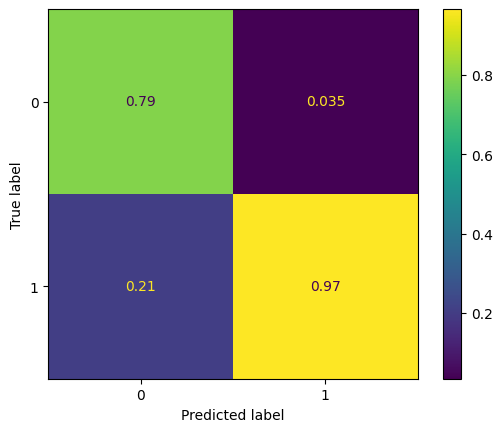

In [ ]:
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_en, test_ds_predicted , normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
Y_test_en[100]

1

In [ ]:
wrong_pred_ind_nb = []
good_pred_ind_nb = []
ground_truth_ind_nb = []
ground_truth_nb = []
wrong_pred_sentences_nb = []
good_pred_sentences_nb = []
for i in range(0, len(test_ds_predicted)):
  if test_ds_predicted[i] != Y_test_en[i]:
    wrong_pred_ind_nb.append(test_ds_predicted[i])
    ground_truth_ind_nb.append(Y_test_en[i])
    wrong_pred_sentences_nb.append(X_test_nb[i])
  if test_ds_predicted[i] == Y_test_en[i]:
    good_pred_ind_nb.append(test_ds_predicted[i])
    ground_truth_nb.append(Y_test_en[i])
    good_pred_sentences_nb.append(X_test_nb[i])
    #print(f"{i}.  {X_test_nb[i]} - hate speech prediction {test_ds_predicted[i]}, ground truth: {Y_test_en[i]}")

In [ ]:
df_nb_g = pd.DataFrame(list(zip(good_pred_sentences_nb, good_pred_ind_nb, ground_truth_nb )), columns =['Sentence', 'Prediction', 'Ground Truth'])
df_nb_g

,Sentence,Prediction,Ground Truth
0,i got a missed call from yo bitch,1,1
1,fucking with a bad bitch you gone need some mo...,1,1
2,rt wipe the cum out of them faggot rt contact ...,1,1
3,niggas cheat on they bitch and do not expect n...,1,1
4,mother asked what i wanted for christmas this ...,1,1
...,...,...,...
4628,haha ight nig calm yoself,1,1
4629,when you see kids being bad their parents just...,1,1
4630,this bitch done blew my high,1,1
4631,fat trel that niggah,1,1


In [ ]:
df_nb = pd.DataFrame(list(zip(wrong_pred_sentences_nb, wrong_pred_ind_nb, ground_truth_ind_nb )), columns =['Sentence', 'Prediction', 'Ground Truth'])
df_nb

,Sentence,Prediction,Ground Truth
0,"lol my credit are not no where near good , but...",1,0
1,got to love it when the islamofascist cow trie...,0,1
2,i am just tryna get to sleep before the birds ...,1,0
3,you say waste a draft pick on manziel when we ...,0,1
4,seeing elder queer couples marry really is emo...,0,1
...,...,...,...
319,"""i play soccer, cheat on girls, and wear khaki...",0,1
320,"sniffs whiffy balls involuntary, cuz a fairy w...",1,0
321,hes just a friggin idiot that can say anything...,0,1
322,so real it is unreal lol,1,0


In [ ]:
df_wrong_pred = df_nb[(df_nb['Prediction']==1) & (df_nb['Ground Truth']==0)]

In [ ]:
df_wrong_pred[:45]

,Sentence,Prediction,Ground Truth
0,"lol my credit are not no where near good , but...",1,0
2,i am just tryna get to sleep before the birds ...,1,0
5,"out of day care, i am taking a kitty nap on yo...",1,0
9,all these afternoon groups are trash besides t...,1,0
10,rt if you like bmth adtr ptv ymas sws atl om,1,0
11,nah. its over people do not tell what do to. t...,1,0
12,virtually zero protections for lgbtq persons i...,1,0
13,ha booner has that twitter ha,1,0
14,go fight against the idf if you progressive tr...,1,0
16,serious question here; how many country songs ...,1,0


**Misconfusing Ground Truth / Predictions**:
* 1. *lol my credit are not no where near good , but i know the right man for the job .. that ho nice though!*  -> This sentence uses "ho" as exclamatory and it is labelled as non-hate speech. This is opposite to sentence 81 - * "this ho on lifetime crazy"* -  which uses "ho" as the same exclamatory as well but it is labelled as non-hate speech.
* 14. *go fight against the idf if you progressive trash hate them so much, you do not have the guts to do it.*- this is hate speech. It predicts correctly but the ground truth is wrong..
* 35. "oh snap i am just realizing this skinny tranny is jared leto. he is wo unrecognizable with all that weight loss. geez!!!" - this is hate speech. It predicts correctly but the ground truth is wrong..
* 40. "we do not love deez hoes" - hate speech but in the ground truth no. We personally would say that this is hate speech.

In [ ]:
df_wrong_pred2 = df_nb[(df_nb['Prediction']==0) & (df_nb['Ground Truth']==1)]
df_wrong_pred2[:45]

,Sentence,Prediction,Ground Truth
1,got to love it when the islamofascist cow trie...,0,1
3,you say waste a draft pick on manziel when we ...,0,1
4,seeing elder queer couples marry really is emo...,0,1
6,nobody on planet earth more protective than bu...,0,1
7,god damn birds,0,1
8,"lol avila... it is simple, but i live in a pre...",0,1
15,hey jim you will love this,0,1
21,joan rivers said i was gay and michelle was a ...,0,1
24,i hate when people leave their trash in my car.,0,1
26,rt if you are nerd trash who likes to set thin...,0,1


**Misconfusing Ground Truth**:
* 4. *seeing elder queer couples marry really is emotional. they get to live their final years with equality and with dignity.* - This is not hate speech.
* 7. *god damn birds* - it is not hate speech
* 28. *hell wrong with you all? pecan pie and sweet potato pie trash.* - this is not hate speech
* 30. *"gab and bri both fell asleep on me." - this is not hate speech
* 74. *"what can banks do to show engagement with the queer community?" "hire trans women"* - this is not hate speech.
* 37. *"made homemade chili and cornbread for dinner. and watching supernatural with my fave boys!! happy saturday bitches!"* - this is not hate speech
* 67. *"told ya months ago charlie was not bullshittin.. bevo is next* - not hate speech
* 79. *for about the last hour of getting my stomach tattooed i felt like i was going to puke. god damnit	* - this is not hate speech
* 42. *all of a sudden craving the hell out of cookies.* - this is not hate speech.
* 15. *"hey jim you will love this"* - it is hate speech, why? Poor Jim..
* 24. I hate when people leave their trash in my car
* 83. "stuffed her like an oreo" - it is rude but not hate speech..
* 54. *only word i can understand on is "nigger"... heavily disappointed in this show. aaronmacgruder stuff blows, i am going to.* 82. *vince, what is the general feeling of the natives that you know in regards to the term "redskins"? offensive to them or not?* - it is not used in a negative way but it can be considered as hate speech

In [ ]:
df_truth = df_nb_g[(df_nb_g['Prediction']==1) & (df_nb_g['Ground Truth']==1)]
df_truth[:45]

,Sentence,Prediction,Ground Truth
0,i got a missed call from yo bitch,1,1
1,fucking with a bad bitch you gone need some mo...,1,1
2,rt wipe the cum out of them faggot rt contact ...,1,1
3,niggas cheat on they bitch and do not expect n...,1,1
4,mother asked what i wanted for christmas this ...,1,1
5,that is real dedication. .. this bitch got dia...,1,1
6,"kiss i am going to this conductor, it is : am ...",1,1
7,my momma keep talking to me like bitch gtf i a...,1,1
8,i kno this bitch a thot she want to meet my mo...,1,1
9,like a bitch pic is flirting nowadays,1,1


**FINAL REMARKS** - the labelling seems quite random, without precise boundaries. There are some tweets that makes unpleasant jokes but they are labelled as non-hate speech as well as tweets that contains really negative words like "tranny". <br>
- Iconsistency in labelling
- Some tweets are really difficult to understand (slang)



In [ ]:
i = 101
print(np.where(test_ds_predicted==0)[0][i])
print(X_test_nb[np.where(test_ds_predicted==0)[0][i]])

671
saves you a brownie*


In [ ]:
docs_new = ['love pizza']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = nb_clf.predict(X_new_tfidf)
print(predicted)

[1]


 ### Italian


In [ ]:
# Remove the start token
X_train_nb = [text.replace('<start> ', '') for text in X_train_ita]
X_test_nb = [text.replace('<start> ', '') for text in X_test_ita]
X_train_nb = [text.lower() for text in X_train_nb]
X_test_nb = [text.lower() for text in X_test_nb]

In [ ]:
count_vect = CountVectorizer(stop_words=stopwords.words('italian'))
X_train_counts = count_vect.fit_transform(X_train_nb)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

nb_clf = BernoulliNB()

# Multiply each sample by the corresponding class
sample_weights = class_weights[Y_train_ita]

nb_clf.fit(X_train_tfidf, Y_train_ita, sample_weights)

BernoulliNB()

In [ ]:
X_new_counts = count_vect.transform(X_test_nb)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

test_ds_predicted_ita = nb_clf.predict(X_new_tfidf)

In [ ]:
print(metrics.classification_report(Y_test_ita,test_ds_predicted_ita))

              precision    recall  f1-score   support

           0       0.61      0.97      0.75      1349
           1       0.83      0.18      0.29      1019

    accuracy                           0.63      2368
   macro avg       0.72      0.57      0.52      2368
weighted avg       0.70      0.63      0.55      2368



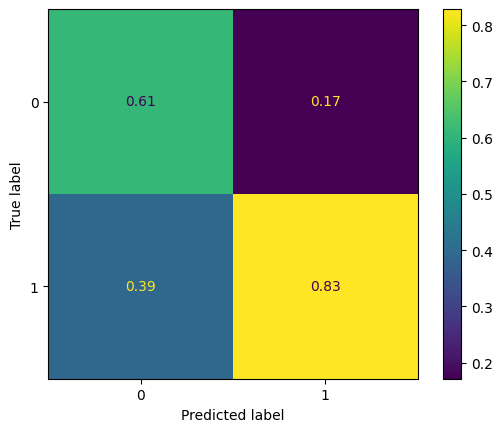

In [ ]:
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_ita, test_ds_predicted_ita , normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
wrong_pred_ind_nb_ita = []
ground_truth_ind_nb_ita = []
wrong_pred_sentences_nb_ita = []

good_pred_ind_nb_ita = []
ground_truth_nb_ita = []
good_pred_sentences_nb_ita = []

for i in range(0, len(test_ds_predicted_ita)):
  if test_ds_predicted_ita[i] != Y_test_ita[i]:
    wrong_pred_ind_nb_ita.append(test_ds_predicted_ita[i])
    ground_truth_ind_nb_ita.append(Y_test_ita[i])
    wrong_pred_sentences_nb_ita.append(X_test_nb[i])
  if test_ds_predicted_ita[i] == Y_test_ita[i]:
    good_pred_ind_nb_ita.append(test_ds_predicted_ita[i])
    ground_truth_nb_ita.append(Y_test_ita[i])
    good_pred_sentences_nb_ita.append(X_test_nb[i])

In [ ]:
df_nb_g_ita = pd.DataFrame(list(zip(good_pred_sentences_nb_ita, good_pred_ind_nb_ita, ground_truth_nb_ita )), columns =['Sentence', 'Prediction', 'Ground Truth'])

In [ ]:
df_nb_ita = pd.DataFrame(list(zip(wrong_pred_sentences_nb_ita, wrong_pred_ind_nb_ita, ground_truth_ind_nb_ita )), columns =['Sentence', 'Prediction', 'Ground Truth'])

In [ ]:
df_truth_ita = df_nb_g_ita[(df_nb_g_ita['Prediction']==1) & (df_nb_g_ita['Ground Truth']==1)]
df_truth_ita[:45]

,Sentence,Prediction,Ground Truth
1,l'immigrazione di massa è invasione sempre. ri...,1,1
31,ti sfonderei e ti allargherei la figa e poi t...,1,1
38,ma che splendida lavata di sborra calda mentr...,1,1
40,allargala tutta con le dita che te lo infilo ...,1,1
44,"e va beh, mica ha detto che i gay son malati ...",1,1
51,culone pensa solo riempirci di musulmani e is...,1,1
63,posson riportare culona nel pollaio. ma senza ...,1,1
77,inviati un bel gruppo immigrati nei centri soc...,1,1
82,🤮🤮🤮🤮🤮 purtroppo so che merda feccia canceroge...,1,1
102,immigrati: il trucco dei ricongiungimenti per ...,1,1


In [ ]:
df_wrong_pred_ita = df_nb_ita[(df_nb_ita['Prediction']==0) & (df_nb_ita['Ground Truth']==1)]
df_wrong_pred_ita[:45]

,Sentence,Prediction,Ground Truth
0,bianca troiona succhiacazzi... perdipiu' brutt...,0,1
1,"troia ,succhiacazzi , infame e comunista",0,1
2,sei una cagna — quella è tua mamma zì,0,1
3,: un attacco con coltello alla vigilia di in u...,0,1
4,"....ecco....i migranti che, secondo , hanno g...",0,1
5,bastava non fare entrare stranieri prima!!! o...,0,1
6,oh!! ma sta a vedere che era un androide e no...,0,1
7,"vescovo: “basta immigrati, vanno aiutati a cas...",0,1
8,alla fine culona si fatta spazio!!!,0,1
9,"bisogna sia reato ,una multa solo se è "" becca...",0,1


* 11. "ahhh! sono sul poggiolo (con i pantaloni del pigiama natalizio (lol) e una maglia di mio cugino, le pantofole) passa uno in macchina e mi urla “bella figa” ma che cazzo di problemi hai!! coglione. chi ti da il permesso di urlarmi “complimenti” tieniteli per te i tuoi pensieri	" - even if it is not hate speech, this sentence present a pretty violent language so it is understandable that the algorithm predicts in a wrong way.

In [ ]:
df_wrong_pred_ita2 = df_nb_ita[(df_nb_ita['Prediction']==1) & (df_nb_ita['Ground Truth']==0)]
df_wrong_pred_ita2[:45]

,Sentence,Prediction,Ground Truth
11,ahhh! sono sul poggiolo (con i pantaloni del p...,1,0
19,tutto regolare. la povertà è abolita per gli ...,1,0
58,tre cittadini stranieri davano stupefacenti i...,1,0
154,"hai ragione, chi arriva da noi non è certo un...",1,0
163,come f definisce b:-un cucciolo di libellula-u...,1,0
176,contro il e contro la : due facce della stessa...,1,0
182,"i figli di puttana, i figli di troia, gli infa...",1,0
188,vi invito a pensare: il sig. bergoglio sta pre...,1,0
190,nessuna meraviglia per i buoni musulmani le do...,1,0
194,"la città è allo sfascio: disoccupazione, delin...",1,0


* 163: *"come f definisce b:-un cucciolo di libellula-una bellissima farfallina-un'iguana delle savanecome b definisce f:-una puttanella-balena spiaggiata-brutta troietta-stupida bitchin tutto ciò ho capito che fè è la troia della situazione.."* - Mislabelled
* 190: *nessuna meraviglia per i buoni musulmani le donne occidentali sono prostitute ed infedeli e come tali le trattano. bandire l'islam dal ns paese anziché accoglierlo è l'unica soluzione url* - ;islabelled

In [ ]:
#docs_new = ['nessuna meraviglia per i buoni musulmani le donne occidentali sono prostitute ed infedeli e come tali le trattano. bandire l islam dal ns paese anziché accoglierlo è l unica soluzione url']
docs_new = ['ormai i sindacati hanno a cuore gli immigrati a scapito dei lavoratori italiani...facendo scendere salari stipendi etc pur di fare qualche tessera...unico loro scopo']
#docs_new = ['ciao lucrezya buona sera e buona serata quanto figa e sexy ti scoperei ?	']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = nb_clf.predict(X_new_tfidf)
print(predicted)

[1]


* With long sentences it predicts one whether with short sentences it tends to predict 0

In [ ]:
"""wrong_pred_ind_nb = []
good_pred_ind_nb = []
ground_truth_ind_nb = []
ground_truth_nb = []
wrong_pred_sentences_nb = []
good_pred_sentences_nb = []
for i in range(0, len(test_ds_predicted)):
  if test_ds_predicted[i] != Y_test_en[i]:
    wrong_pred_ind_nb.append(test_ds_predicted[i])
    ground_truth_ind_nb.append(Y_test_en[i])
    wrong_pred_sentences_nb.append(X_test_nb[i])
  if test_ds_predicted[i] == Y_test_en[i]:
    good_pred_ind_nb.append(test_ds_predicted[i])
    ground_truth_nb.append(Y_test_en[i])
    good_pred_sentences_nb.append(X_test_nb[i])
    #print(f"{i}.  {X_test_nb[i]} - hate speech prediction {test_ds_predicted[i]}, ground truth: {Y_test_en[i]}")"""

## Definition of the model

Basic convolutional network taken from [this blog](https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/), single-value output ranging from 0 to 1 indicating if its a hate speech tweet or not.

Convolutional neural networks were designed to honor the spatial structure in image data while being robust to the position and orientation of learned objects in the scene.

This same principle can be used on sequences, such as the one-dimensional sequence of words in a movie review. The same properties that make the CNN model attractive for learning to recognize objects in images can help to learn structure in paragraphs of words, namely the techniques invariance to the specific position of features.

In [42]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
WEIGHTS = embedding_matrix_en

# Model
cnn_model = Sequential()
# ------
cnn_model.add(keras.layers.Embedding(VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM, input_length=SEQ_LENGTH, weights=[WEIGHTS], trainable=False))
# ------
cnn_model.add(keras.layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
cnn_model.add(keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dense(256, activation='relu'))
cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])

print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          6000600   
                                                                 
 conv1d (Conv1D)             (None, 300, 64)           96064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 9600)              0         
                                                                 
 dense (Dense)               (None, 256)               2457856   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                        

In [44]:
NUM_EPOCHS=10
BATCH_SIZE=64

earlystop = EarlyStopping(monitor='val_loss', patience=3)

cnn_model.fit(X_train_en_padded, Y_train_en, validation_data=(X_test_en_padded, Y_test_en), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[earlystop], class_weight=class_weights_dict)

print("\n")

# Final evaluation of the model
scores = cnn_model.evaluate(X_test_en_padded, Y_test_en)
print("Accuracy: %.2f%%" % (scores[1]*100))

NameError: ignored

155/155 [==============================] - 1s 5ms/step


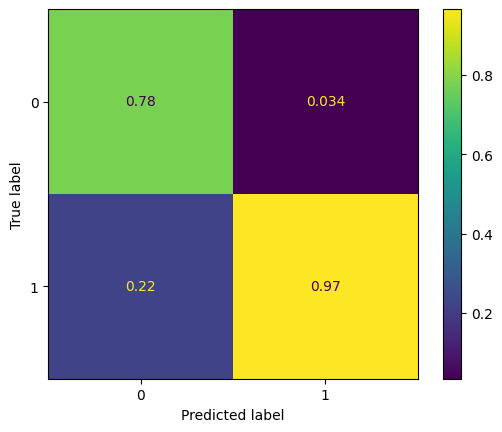

In [ ]:
#Predict
y_prediction_en = cnn_model.predict(X_test_en_padded)
y_prediction_en = (y_prediction_en >= 0.5).astype(int)

#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_en, y_prediction_en , normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
X_test_en_padded

array([[    2,    32,  1394, ...,     0,     0,     0],
       [    2,    79,    83, ...,     0,     0,     0],
       [    2,    55,  2125, ...,     0,     0,     0],
       ...,
       [    2,     6,   268, ...,     0,     0,     0],
       [    2,   183, 14779, ...,     0,     0,     0],
       [    2,     1,   225, ...,     0,     0,     0]], dtype=int32)

In [68]:
X_test_pr = [text.replace('<start> ', '') for text in X_test_en]

In [ ]:
wrong_pred_ind_cnn = []
ground_truth_ind_cnn = []
wrong_pred_sentences_cnn = []

good_pred_cnn = []
ground_truth_cnn = []
good_pred_sentences_cnn = []

for i in range(0, len(y_prediction_en)):
  if y_prediction_en[i] != Y_test_en[i]:
    wrong_pred_ind_cnn.append(y_prediction_en[i][0])
    ground_truth_ind_cnn.append(Y_test_en[i])
    wrong_pred_sentences_cnn.append(X_test_pr[i])
  if y_prediction_en[i] == Y_test_en[i]:
     good_pred_cnn.append(y_prediction_en[i][0])
     ground_truth_cnn.append(Y_test_en[i])
     good_pred_sentences_cnn.append(X_test_pr[i])

In [ ]:
df_cnn_g = pd.DataFrame(list(zip(good_pred_sentences_cnn, good_pred_cnn, ground_truth_cnn)), columns =['Sentence', 'Prediction', 'Ground Truth'])
df_cnn_g[:45]

,Sentence,Prediction,Ground Truth
0,well how else will white people get us to forg...,1,1
1,Funny thing is....it is not just the people do...,1,1
2,bitch ass nigggaaa,1,1
3,S/o that real bitch,1,1
4,speaking about me all the time tryna make me l...,1,1
5,Nah Mimi a bitch,1,1
6,""": Baseball season for the win. "" This is wher...",1,1
7,you always hatin lmao,1,1
8,Why are nudes called nudes? I would rather be ...,1,1
9,RT Baby I cooked Bae: What is for dinner? Me: ...,1,1


In [ ]:
df_cnn = pd.DataFrame(list(zip(wrong_pred_sentences_cnn, wrong_pred_ind_cnn, ground_truth_ind_cnn )), columns =['Sentence', 'Prediction', 'Ground Truth'])

In [ ]:
df_cnn[(df_cnn['Prediction']==1) & (df_cnn['Ground Truth']==0)]

,Sentence,Prediction,Ground Truth
0,""": "": Nigga messed with the wrong bitch",1,0
2,But no joke I will say NO IT IS NOT an Oleande...,1,0
4,""": oh yeah fuck that bitch",1,0
7,"And i did not want to come off as a bitch, so ...",1,0
8,You scared I are not scared to beat the pussy up,1,0
...,...,...,...
326,its time. amend th amendment it was written to...,1,0
329,I do not fuck wit these bitches cuz they think...,1,0
330,Legion of jig,1,0
331,Never seen yo bitch but I bet I could fuck her...,1,0


* 37 - *"I am Hun-gry*" - the model is wrong
* 4 - *" oh yeah fuck that bitch*" - for us the ground truth should be zero.


In [ ]:
c

,Sentence,Prediction,Ground Truth
1,You bitches make me sick,0,1
3,homo ass crackers,0,1
5,.....hate to sound all callous and all...........,0,1
6,Colts nation...put you all money up chuassup w...,0,1
11,too bad you are a pussy,0,1
...,...,...,...
327,This is so much fun!,0,1
328,Over-thinking can and will fuck up the simples...,0,1
332,Ya bitch pussy good I are not heard it .... I ...,0,1
334,"I can tweet ""I do not fw crayons"" and my ex go...",0,1


### Some tests

In [ ]:
id = 10

tweet = np.array([X_test_en_padded[id]])

print(test_en.iloc[id]['tweet'], " | ", test_en.iloc[id]['hate_speech'])

cnn_model.predict(tweet)

AttributeError: ignored

In [ ]:
slim = y_prediction_en.reshape(-1)
hate = np.where(slim == 1)[0]
test = t_en.sequences_to_texts(X_test_en_padded[hate])

In [ ]:
test[10]

'<start> like bitch pic flirting nowadays <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

In [ ]:
fake_tweet = "The young man is neither autistic nor the son of the other man. He has Down Syndrome and he is not with is father."
fake_tweet = preprocess_text_for_test(fake_tweet, t_en)
fake_tweet = tf.keras.utils.pad_sequences(fake_tweet, maxlen=SEQ_LENGTH, padding='post', truncating='post')


cnn_model.predict(fake_tweet)

1/1 [==============================] - 0s 21ms/step


array([[0.33254457]], dtype=float32)

### Ita

In [ ]:
cnn_model.layers[0].set_weights([embedding_matrix_it])

74/74 [==============================] - 0s 2ms/step


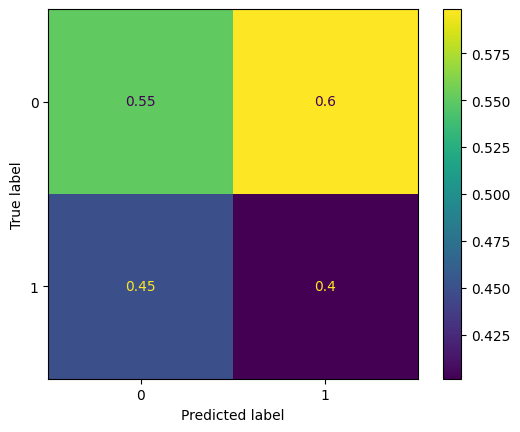

In [ ]:
#Predict
y_prediction_ita = cnn_model.predict(X_test_ita_padded)
y_prediction_ita = (y_prediction_ita >= 0.5).astype(int)

#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_ita, y_prediction_ita , normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [113]:
X_test_pr_ita = [text.replace('<start> ', '') for text in X_test_ita]

In [ ]:
wrong_pred_ind_cnn_ita = []
ground_truth_ind_cnn_ita = []
wrong_pred_sentences_cnn_ita = []
for i in range(0, len(y_prediction_ita)):
  if y_prediction_ita[i] != Y_test_ita[i]:
    wrong_pred_ind_cnn_ita.append(y_prediction_ita[i][0])
    ground_truth_ind_cnn_ita.append(Y_test_ita[i])
    wrong_pred_sentences_cnn_ita.append(X_train_pr_ita[i])

In [ ]:
df_cnn_ita = pd.DataFrame(list(zip(wrong_pred_sentences_cnn_ita, wrong_pred_ind_cnn_ita, ground_truth_ind_cnn_ita )), columns =['Sentence', 'Prediction', 'Ground Truth'])
df_cnn_ita

,Sentence,Prediction,Ground Truth
0,TRUMP HA LANCIATO MISSILI A DESTRA E MANCA IN ...,0,1
1,Ssp: nelle carceri la metà degli stranieri è p...,1,0
2,"Campo rom a Roma Nord: ""A Prima Porta fino al ...",1,0
3,Quel coglione di Francese in stato di fermo pe...,1,0
4,Immigrati nudi al balcone (foto) e con i genit...,1,0
...,...,...,...
1200,"Diciotti, Baobab: 'Non è reato accompagnare i ...",0,1
1201,gli islamici sono tutti integralisti. io però ...,1,0
1202,Senza considerare che il % delle famiglie degl...,1,0
1203,Roma: un turista giapponese viene accerchiato ...,1,0


In [ ]:
slim = y_prediction_ita.reshape(-1)
hate = np.where(slim == 1)[0]
X_test_ita_padded[hate]
test = t_it.sequences_to_texts(X_test_ita_padded[hate])

In [ ]:
test[24]

'<start> sì twitter messo <unk> <unk> <unk> porca puttana <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

In [ ]:
fake_tweet = "Nuovo sfregio al Colosseo, una turista svizzera incide le sue iniziali: rischia il carcere e una maximulta. E' stata filmata da una guida e denunciata"
fake_tweet = "Ma va a morì ammazzato stronzo di merda. Pensa piuttosto a tornartene a casa tua ASSASSINO ! P.s voi russi le bombe a grappolo le state usando sin dall'inizio di quest'infame aggressione al popolo ucraino."
fake_tweet = preprocess_text_for_test(fake_tweet, t_it)
fake_tweet = tf.keras.utils.pad_sequences(fake_tweet, maxlen=SEQ_LENGTH, padding='post', truncating='post')

cnn_model.predict(fake_tweet)

1/1 [==============================] - 0s 62ms/step


array([[0.9640827]], dtype=float32)

alora

non funziona molto bene anche se ho seguito per bene tutto quello che fa il tipo

1. secondo me è proprio per differenze linguistiche, teoricamente con i pesi dell'embedding in inglese ha capito come classificare i tweet riconoscendo la presenza di certe parole, e di conseguenza la loro posizione nello spazio dell'embedding
  
  cambiando l'embedding lui si aspetta di trovare parole brutte in certe posizioni spaziali con determinate relazioni che probabilmente non si preservano nello spazio italiano

2. nonostante i risultati sia in inglese che in ita non siano poi così male, secondo me non performa comunque bene, ma credo la motivazione sia 50/50 dati e modello

3. i dati non sono un gran chè (come sono classificati) e con il nostro modello semplice semplice secondo me scegle le label in maniera conservativa, sparando 1 appena trova una minima parolaccia

4. in italiano non ho la più pallida idea di cosa reputi parolaccia, puoi scrivere le peggio cose e non lo labellllerà come offesa, sus......

update rispetto qua sopra

1. Non è vero, ho dimostrato che l'embedding è quello multilingual, quindi fico, parole più o meno nella stessa posizione poichè lo spazio è "allineato"

  Il problema è che l'allineamento non è perfetto, cercando per NN si trovano le parole, ma ovviamente non sono vicine vicine, probabilmente questo nel modello fa si che la sua convinzione nel define qualcosa hate sia meno forte rispetto che in inglese, tipo poco sopra 0.5

2. in realtà no, dipende dal modello. Essendo cnn come detto cerca corrispondenze spaziali e quindi secondo me ha imparato a riconoscere certe parole come "nono word" e ogni volta che le trova aumenta notevolmente la probabilità di essere classificato hs (e.g i fucking love pizzzza)

3. forse si i dati non sono un granchè, e labella in maniera conservativa come detto in punto 2. Il vero problema forse sta anche nella differenza di come sono le frasi in italiano rispetto l'inglese. Forse in eng gli insulti sono più diretti/semplici (?) mentre in italiano sono molto più lunghi e boh incentrati sui migranti/politica (?)

4. Confermo :)


## LSTM Model

From: https://github.com/mdabashar/Deep-Learning-Algorithms/blob/master/LSTM%20Hate%20Speech%20Detection.ipynb

BASELINE: https://www.researchgate.net/figure/Baseline-LSTM-model-architecture_fig2_363399494

In [50]:
WEIGHTS = embedding_matrix_en #embedding_matrix_it

#baseline LSTM architecture from the paper
def lstm_model(embedding_matrix=WEIGHTS, input_length = SEQ_LENGTH):
    input = keras.layers.Input(shape=(SEQ_LENGTH,), dtype='int32')
    encoder = keras.layers.Embedding(VOCABULARY_SIZE+INDEX_FROM-1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=input_length, trainable=False)(input)
    x = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.5, return_sequences=True))(encoder)
    #x = keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.5,return_sequences=True))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128)(x)
    x = keras.layers.Dense(1)(x)
    output = keras.layers.Activation('sigmoid')(x)
    model = Model(inputs=[input], outputs=[output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', f1_m, precision_m, recall_m]) #adamW
    return model

lstm_model = lstm_model()
lstm_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 300, 300)          6000600   
                                                                 
 bidirectional_2 (Bidirectio  (None, 300, 128)         186880    
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 38400)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               4915328   
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                           

In [52]:
NUM_EPOCHS=20
BATCH_SIZE=32

earlystop = EarlyStopping(monitor='val_loss', patience=3)

lstm_model.fit(X_train_en_padded, Y_train_en, validation_data=(X_test_en_padded, Y_test_en), epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[earlystop], class_weight=class_weights_dict)

print("\n")

# Final evaluation of the model
scores = lstm_model.evaluate(X_test_en_padded, Y_test_en)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/20
620/620 [==============================] - 18s 29ms/step - loss: 0.2892 - acc: 0.8753 - f1_m: 0.9173 - precision_m: 0.9786 - recall_m: 0.8705 - val_loss: 0.2246 - val_acc: 0.9028 - val_f1_m: 0.9374 - val_precision_m: 0.9898 - val_recall_m: 0.8918
Epoch 2/20
620/620 [==============================] - 18s 28ms/step - loss: 0.2136 - acc: 0.9041 - f1_m: 0.9383 - precision_m: 0.9901 - recall_m: 0.8939 - val_loss: 0.2184 - val_acc: 0.9046 - val_f1_m: 0.9384 - val_precision_m: 0.9933 - val_recall_m: 0.8909
Epoch 3/20
620/620 [==============================] - 19s 30ms/step - loss: 0.1907 - acc: 0.9141 - f1_m: 0.9450 - precision_m: 0.9919 - recall_m: 0.9045 - val_loss: 0.1861 - val_acc: 0.9165 - val_f1_m: 0.9466 - val_precision_m: 0.9918 - val_recall_m: 0.9066
Epoch 4/20
620/620 [==============================] - 17s 28ms/step - loss: 0.1765 - acc: 0.9203 - f1_m: 0.9493 - precision_m: 0.9936 - recall_m: 0.9104 - val_loss: 0.2119 - val_acc: 0.9120 - val_f1_m: 0.9434 - val_precision_m

155/155 [==============================] - 3s 12ms/step


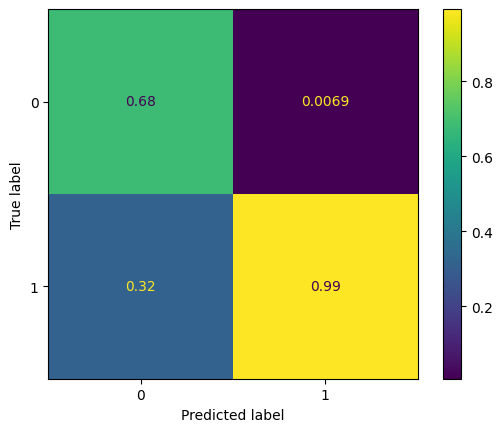

In [53]:
#Predict
y_prediction_en = lstm_model.predict(X_test_en_padded)
y_prediction_en = (y_prediction_en >= 0.5).astype(int)

#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_en, y_prediction_en , normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [69]:
wrong_pred_ind_ltsm = []
ground_truth_ind_lstm = []
wrong_pred_sentences_lstm = []

good_pred_lstm = []
ground_truth_lstm = []
good_pred_sentences_lstm = []

for i in range(0, len(y_prediction_en)):
  if y_prediction_en[i] != Y_test_en[i]:
    wrong_pred_ind_ltsm.append(y_prediction_en[i][0])
    ground_truth_ind_lstm.append(Y_test_en[i])
    wrong_pred_sentences_lstm.append(X_test_pr[i])
  if y_prediction_en[i] == Y_test_en[i]:
     good_pred_lstm.append(y_prediction_en[i][0])
     ground_truth_lstm.append(Y_test_en[i])
     good_pred_sentences_lstm.append(X_test_pr[i])

In [119]:
#analysis on good predictions
df_lstm_g = pd.DataFrame(list(zip(good_pred_sentences_lstm, good_pred_lstm, ground_truth_lstm)), columns =['Sentence', 'Prediction', 'Ground Truth'])
df_lstm_g[:45]

,Sentence,Prediction,Ground Truth
0,i got a missed call from yo bitch,1,1
1,Fucking with a bad bitch you gone need some mo...,1,1
2,"lol my credit are not no where near good , but...",0,0
3,RT Wipe the cum out of them faggot RT Contact ...,1,1
4,Niggas cheat on they bitch and do not expect n...,1,1
5,Mother asked what I wanted for Christmas this ...,1,1
6,That is real dedication. .. This bitch got dia...,1,1
7,"Kiss I AM GOING TO this conductor, it is : AM ...",1,1
8,My momma keep talking to me like bitch gtf I a...,1,1
9,I kno this bitch a thot she want to meet my mo...,1,1


In [84]:
df_lstm = pd.DataFrame(list(zip(wrong_pred_sentences_lstm, wrong_pred_ind_ltsm, ground_truth_ind_lstm )), columns =['Sentence', 'Prediction', 'Ground Truth'])

In [85]:
len(df_lstm)

403

In [87]:
#26 wrong predictions
df_lstm[(df_lstm['Prediction']==1) & (df_lstm['Ground Truth']==0)]

,Sentence,Prediction,Ground Truth
6,"KaasPiet,bloemPiet.?lol men weet van gekkighei...",1,0
25,"Sometimes, even I got to tell these hoes to gr...",1,0
45,Surrender of Divinity - Conquerors of the Apoc...,1,0
48,We do not love deez hoes,1,0
71,""": hoes Austin teach us Austin.""I teach you ho...",1,0
97,""": Overdosing on heavy drugs does not sound ba...",1,0
101,RT Food be good...except that rice they cook t...,1,0
114,"I would bitch about the weather being bipolar,...",1,0
158,"""Never go full retard""",1,0
172,As a kid I listened to Nas. He showed me a new...,1,0


* 296 "Log off nigger" - Prediction 1 - Ground Truth: 0
- 47 "We do not love deez hoes"  - Prediction 1 - Ground Truth: 0
- 25 - "Sometimes, even I got to tell these hoes to grow up smh"
- 176 - "I got a uncle through marriage dude got hips like big momma I swear all the lil kids mock his walk and he do not even know it" - body shaming
- 256 Hmu talmbout match but when I pull up its other niccas wit ya

In [89]:
df_lstm[(df_lstm['Prediction']==0) & (df_lstm['Ground Truth']==1)]

,Sentence,Prediction,Ground Truth
0,what did you search? Gay redneck episode play?,0,1
1,got to love it when the islamofascist cow trie...,0,1
2,you say waste a draft pick on Manziel when we ...,0,1
3,"Damn "": It is kind of trash man RT "": How many...",0,1
4,aight game over. dykes had to ruin it,0,1
...,...,...,...
398,"These nigs is haters man, and I have made myse...",0,1
399,"""I play soccer, cheat on girls, and wear khaki...",0,1
400,Dey gave da wrong nicca money,0,1
401,uh you are trash.,0,1


* 5 - Seeing elder queer couples marry really is emotional. They get to live their final years with equality and with dignity.	-> ground truth is 1 but this sentence is not hate speech
* 6 - God damn birds	-> ground truth is 1 but this sentence is not hate speech
* 7 - Hey Jim you will love this	-> maybe it had a link but it is not hate speech in this context
* 14 - I am retarded hungover and all we had were beers. A lot of beers.	--> this is not hate speech
* 21 - that is what i call it too !! Lol its beyond ghetto smh but man you needa quit playin and come back	-> this is not really hate speech
* 32 - "chink eyed !" -> is not hate speech
* 47 - "Sorry fo da rant. It make me mad and ashamed to be colored. I wish I be white so you all would like me" - this is not hate speech, this is just a sed tweet.
* 48 - Come over queer - this is not hate speech
* 57 - "chill zahra i am getting crackers right now" - this is not hate speech
* 86 - "beer queer"
* 94 - ""what can banks do to show engagement with the queer community?" "HIRE TRANS WOMEN""

In [90]:
fake_tweet = "i fucking love pizza"
#fake_tweet = "you are retarded"
fake_tweet = preprocess_text_for_test(fake_tweet, t_en)
fake_tweet = tf.keras.utils.pad_sequences(fake_tweet, maxlen=SEQ_LENGTH, padding='post', truncating='post')

lstm_model.predict(fake_tweet)

1/1 [==============================] - 0s 42ms/step


array([[0.5422877]], dtype=float32)

### Change the embedding to ita

In [109]:
lstm_model.layers[1].set_weights([embedding_matrix_it])

74/74 [==============================] - 1s 10ms/step


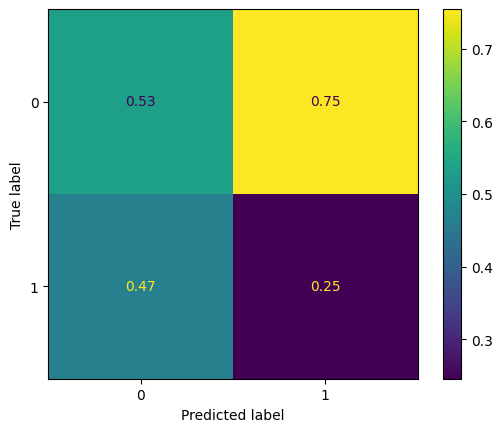

In [110]:
#Predict
y_prediction_ita = lstm_model.predict(X_test_ita_padded)
y_prediction_ita = (y_prediction_ita >= 0.5).astype(int)

#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_ita, y_prediction_ita , normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [122]:
wrong_pred_ind_lstm_ita = []
ground_truth_ind_lstm_ita = []
wrong_pred_sentences_lstm_ita = []

good_pred_lstm_ita = []
ground_truth_lstm_ita = []
good_pred_sentences_lstm_ita = []

for i in range(0, len(y_prediction_ita)):
  if y_prediction_ita[i] != Y_test_ita[i]:
    wrong_pred_ind_lstm_ita.append(y_prediction_ita[i][0])
    ground_truth_ind_lstm_ita.append(Y_test_ita[i])
    wrong_pred_sentences_lstm_ita.append(X_test_pr_ita[i])
  if y_prediction_ita[i] == Y_test_ita[i]:
    good_pred_lstm_ita.append(y_prediction_ita[i][0])
    ground_truth_lstm_ita.append(Y_test_ita[i])
    good_pred_sentences_lstm_ita.append(X_test_pr_ita[i])

In [123]:
#analysis on good predictions
df_lstm_g_ita = pd.DataFrame(list(zip(good_pred_sentences_lstm_ita, good_pred_lstm_ita, ground_truth_lstm_ita)), columns =['Sentence', 'Prediction', 'Ground Truth'])
df_lstm_g_ita[:45]

,Sentence,Prediction,Ground Truth
0,"Ci sono pure rom in Italia, di cui la metà co...",0,0
1,"Il Califfo non è stato sconfitto.Puntland, mil...",0,0
2,"Troia ,succhiacazzi , infame e comunista",1,1
3,Io mi sono messa avanti... Ho fatto comperare...,0,0
4,Porca puttana ho appena evitato per un pelo un...,0,0
5,in linea con il comune sentire. Va promosso l...,0,0
6,Tutti gli immigrati regolari che si fanno i se...,0,0
7,ma poi come se le tette grandi debbano per for...,0,0
8,"Gli spagnoli salvano i migranti e vogliono ""di...",0,0
9,Tanto per chiarire cari romani complottisti e ...,0,0


In [124]:
df_lstm_ita = pd.DataFrame(list(zip(wrong_pred_sentences_lstm_ita, wrong_pred_ind_ltsm_ita, ground_truth_ind_lstm_ita)), columns =['Sentence', 'Prediction', 'Ground Truth'])

In [125]:
df_lstm_ita[(df_lstm_ita['Prediction']==0) & (df_lstm_ita['Ground Truth']==1)]

,Sentence,Prediction,Ground Truth
0,Bianca troiona succhiacazzi... Perdipiu' brutt...,0,1
1,L'immigrazione di massa è invasione sempre. Ri...,0,1
4,Sei una cagna — Quella è tua mamma zì,0,1
5,: Un attacco con coltello alla vigilia di in u...,0,1
6,"....ecco....i migranti che, secondo , hanno g...",0,1
...,...,...,...
1212,"Puttana tua madre quella baldracca, figlio di...",0,1
1213,Vuoi fare una cosa buona ? Almeno una ? Non f...,0,1
1214,Mammmm che tettona meravigliosa,0,1
1215,e noi a Follonica facciamo la recita di natal...,0,1


* oh!! ma sta a vedere che era un androide e non una donna comune!!!	--> non è proprio hate speech

In [128]:
df_lstm_ita[(df_lstm_ita['Prediction']==1) & (df_lstm_ita['Ground Truth']==0)]

,Sentence,Prediction,Ground Truth
2,e porca puttana allora non sono l’unica.,1,0
3,PORCA PUTTANA ELETTRA MI VUOI DARE IL NUMERO D...,1,0
7,porca puttana ma che cazzo faiiiiRicordati ch...,1,0
8,I MARS HANNO FATTO THE KILL FULL BAND PORCA PU...,1,0
10,"Porca puttana, si salvi chi può...",1,0
...,...,...,...
1203,L'arbitro ha avuto una personalità della mado...,1,0
1204,PORCA PUTTANA LADRA SCHIFOSA IERI HARRY STYLES...,1,0
1216,"Già che è domanica mi rode il culo, poi ho dor...",1,0
1217,Ma Achille Lauro è frocio? — che cazzo te ne f...,1,0


All sentences involving "porca puttana" are classified as hate speech.

In [ ]:
"""slim = y_prediction_ita.reshape(-1)
hate = np.where(slim == 1)[0]
X_test_ita_padded[hate]
test = t_it.sequences_to_texts(X_test_ita_padded[hate])"""

In [ ]:
#test[231]

'<start> <unk> entrato <unk> carta momento porca puttana oh <unk> nono <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

In [ ]:
fake_tweet = "sei proprio uno stronzo, sparisci immigrato bastardo"
fake_tweet = preprocess_text_for_test(fake_tweet, t_it)
fake_tweet = tf.keras.utils.pad_sequences(fake_tweet, maxlen=SEQ_LENGTH,padding='post', truncating='post')

lstm_model.predict(fake_tweet)

1/1 [==============================] - 0s 38ms/step


array([[0.32669416]], dtype=float32)

---

# TODO

- stampicciare modificando la rete LSTM (se abbiamo voglia anche la cnn)
- abbiamo gestico class imbalance in naive baises?
- facciamo un pelo di random undersampling(?)
- METTERE NOSTRO CARO AMICO BERT, multilinguale sta volta

---

# Transformers


In [ ]:
model_checkpoint = "bert-base-multilingual-uncased"
#model_checkpoint = "nlptown/bert-base-multilingual-uncased-sentiment"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
X_train_bert_en = [text.replace('<start> ', '') for text in X_train_en]
X_test_bert_en = [text.replace('<start> ', '') for text in X_test_en]
X_train_bert_ita = [text.replace('<start> ', '') for text in X_train_ita]
X_test_bert_ita = [text.replace('<start> ', '') for text in X_test_ita]

columns=['tweet','hate_speech']

df_train_bert_en = pd.DataFrame(list(zip(X_train_bert_en, Y_train_en)), columns =columns)
df_test_bert_en = pd.DataFrame(list(zip(X_test_bert_en, Y_test_en)), columns =columns)
df_train_bert_ita = pd.DataFrame(list(zip(X_train_bert_ita, Y_train_ita)), columns =columns)
df_test_bert_ita = pd.DataFrame(list(zip(X_test_bert_ita, Y_test_ita)), columns =columns)

In [ ]:
hg_train_en = datasets.Dataset(pa.Table.from_pandas(df_train_bert_en))
hg_test_en = datasets.Dataset(pa.Table.from_pandas(df_test_bert_en))

hg_test_ita = datasets.Dataset(pa.Table.from_pandas(df_test_bert_ita))

hg_ds = datasets.DatasetDict({"train":hg_train_en, "test":hg_test_en})

#hg_ds["train"] = hg_ds["train"].remove_columns(["__index_level_0__"]) # remove unwanted column
#hg_ds["test"] = hg_ds["test"].remove_columns(["__index_level_0__"]) # remove unwanted column
hg_ds["train"] = hg_ds["test"].rename_column("hate_speech", "label")
hg_ds["test"] = hg_ds["test"].rename_column("hate_speech", "label")

In [ ]:
hg_train_en

Dataset({
    features: ['tweet', 'hate_speech'],
    num_rows: 19826
})

In [ ]:
hg_ds

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label'],
        num_rows: 4957
    })
    test: Dataset({
        features: ['tweet', 'label'],
        num_rows: 4957
    })
})

In [ ]:
def preprocess_functions(batch):
  # Tokenize the input data
  return tokenizer(
    batch["tweet"],
    #max_length=SEQ_LENGTH,
    #padding=True,
    truncation=True)

In [ ]:
tokenized_datasets_en = hg_ds.map(preprocess_functions, batch_size=16, batched=True) #BS CHANGED FRON 16 TO 8
#tokenized_datasets_en.set_format(type="tensorflow", columns=["input_ids", "attention_mask"])

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets_en

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4957
    })
    test: Dataset({
        features: ['tweet', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4957
    })
})

In [ ]:
#model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
from transformers import AutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
BS = 8

In [ ]:
tf_train_set = tokenized_datasets_en["train"].to_tf_dataset(
    columns=["input_ids", "attention_mask",  "label"],
    shuffle=True,
    batch_size=BS,
    collate_fn=data_collator
)

tf_test_set = tokenized_datasets_en["test"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "label"],
    shuffle=False,
    batch_size=BS,
    collate_fn=data_collator
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
from transformers import create_optimizer

batch_size = BS
num_epochs = 4

batches_per_epoch = len(tokenized_datasets_en["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(init_lr=1e-4, num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:
#original weights {0: 2.9786658653846154, 1: 0.6008607103891381}
#class_weights_dict_2 = {0: 1.50, 1: 1.00}

In [48]:
def weighted_binary_crossentropy(y_true, y_pred):     # Apply weights based on class labels
  weights = y_true * class_weights_dict.get(1) + (1 - y_true) * class_weights_dict.get(0)
  #loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
  weighted_loss = loss(y_true, y_pred) * float(weights)
  mean_loss = tf.reduce_mean(weighted_loss)
  return mean_loss#tf.keras.metrics.Mean(weighted_loss)

In [ ]:
#model.compile(optimizer=optimizer, loss=weighted_binary_crossentropy)
model.compile(optimizer=optimizer)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

In [ ]:
model.fit(x=tf_train_set, validation_data=tf_test_set, epochs=num_epochs, callbacks=[reduce_lr])

Epoch 1/4
620/620 [==============================] - 4469s 7s/step - loss: 0.2188 - val_loss: 0.1978 - lr: 7.5000e-05
Epoch 2/4
620/620 [==============================] - ETA: 0s - loss: 0.2148

KeyboardInterrupt: ignored

In [ ]:
sentences = [
    "Sei una lurida troia, ammazzati.",
    "Che belli i gattini"
]

In [ ]:
tokenized = tokenizer(sentences, return_tensors="np", padding="longest")

outputs = model(tokenized).logits

print(outputs)
print()

classifications = np.argmax(outputs, axis=1)
print(classifications)

In [ ]:
from tqdm import tqdm
res = []
start = 0
end = 100
for i in tqdm(range(0, 2200, 100)):
  tokenize = tokenizer(hg_test_ita['tweet'][i:end], return_tensors="np", padding="longest")
  output = model(tokenize).logits
  classification = np.argmax(output, axis=1)
  res.append(classification)
  end = end + 100

In [ ]:
x = np.reshape(res, (len(res), 100)).T
y = x.reshape(-1)
y.shape

In [ ]:
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_ita[:2200], y , normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
from tqdm import tqdm
res = []
start = 0
end = 100
for i in tqdm(range(0, 4800, 100)):
  tokenize = tokenizer(hg_test_en['tweet'][i:end], return_tensors="np", padding="longest")
  output = model(tokenize).logits
  classification = np.argmax(output, axis=1)
  res.append(classification)
  end = end + 100

In [ ]:
x = np.reshape(res, (len(res), 100)).T
y = x.reshape(-1)
y.shape

In [ ]:
#Create confusion matrix and normalizes it over predicted (columns)
cm = confusion_matrix(Y_test_en[:4800], y , normalize='pred')

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
wrong_pred_ind_cnn_ita = []
ground_truth_ind_cnn_ita = []
wrong_pred_sentences_cnn_ita = []

for i in range(0, len(y_prediction_ita)):
  if y_prediction_ita[i] != Y_test_ita[i]:
    wrong_pred_ind_cnn_ita.append(y_prediction_ita[i][0])
    ground_truth_ind_cnn_ita.append(Y_test_ita[i])
    wrong_pred_sentences_cnn_ita.append(X_train_pr_ita[i])

df_cnn_ita = pd.DataFrame(list(zip(wrong_pred_sentences_cnn_ita, wrong_pred_ind_cnn_ita, ground_truth_ind_cnn_ita )), columns =['Sentence', 'Prediction', 'Ground Truth'])
df_cnn_ita

https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment?text=this+is+shit